In [1]:
import os
os.chdir('../asr/')

In [2]:
import torch
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.model import QuartzNetCTC

NOTE! Installing ujson may make loading annotations faster.


## Грузим модель и берем себе кусок данных для экспериментов

In [3]:
cfg = OmegaConf.load("./conf/quarznet_5x5_ru.yaml")

In [4]:
cfg

{'model': {'init_weights': None, 'enc_filters': 1024, 'labels': [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'], 'encoder': {'repeat': 5, 'dropout': 0.0, 'feat_in': 64, 'blocks': [{'filters': 256, 'repeat': 1, 'kernel_size': 33, 'stride': 4, 'dilation': 1, 'residual': False, 'dropout': '${model.encoder.dropout}', 'separable': True}, {'filters': 256, 'repeat': '${model.encoder.repeat}', 'kernel_size': 33, 'stride': 1, 'dilation': 1, 'residual': True, 'dropout': '${model.encoder.dropout}', 'separable': True}, {'filters': 256, 'repeat': '${model.encoder.repeat}', 'kernel_size': 39, 'stride': 1, 'dilation': 1, 'residual': True, 'dropout': '${model.encoder.dropout}', 'separable': True}, {'filters': 512, 'repeat': '${model.encoder.repeat}', 'kernel_size': 51, 'stride': 1, 'dilation': 1, 'residual': True, 'dropout': '${model.encoder.dropout}', 'separable': True}, {'filters': 5

In [5]:
cfg.val_dataloader.batch_size = 100
cfg.val_dataloader.dataset.manifest_name = 'test_opus/crowd/manifest.jsonl'

In [6]:
model = QuartzNetCTC(cfg)
model.eval()
model.freeze()

ckpt = torch.load('data/q5x5_ru_stride_4_crowd_epoch_4_step_9794.ckpt', map_location='cpu')
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [7]:
model.to('cuda:2')
model.device

device(type='cuda', index=2)

In [8]:
features_list, features_len_list = [], []
targets_list, target_len_list = [], []
logprobs_list, encoded_len_list, preds_list = [], [], []

# Отрежем себе кусок валидации для экспериментов
for i, batch in tqdm(enumerate(model.val_dataloader())):
    features, features_len, targets, target_len = batch
    logprobs, encoded_len, preds = model.forward(features.to('cuda:2'), features_len.to('cuda:2'))
    features_list.append(features)
    features_len_list.append(features_len)
    targets_list.append(targets)
    target_len_list.append(target_len)
    logprobs_list.append(logprobs)
    encoded_len_list.append(encoded_len)
    preds_list.append(preds)
    if i == 5:
        break

5it [00:12,  2.58s/it]


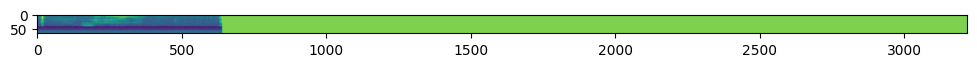

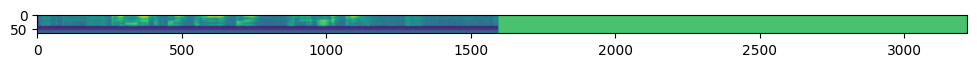

In [9]:
for feature in features[:2]:
    plt.figure(figsize=(12, 5))
    plt.imshow(feature)
    plt.show()

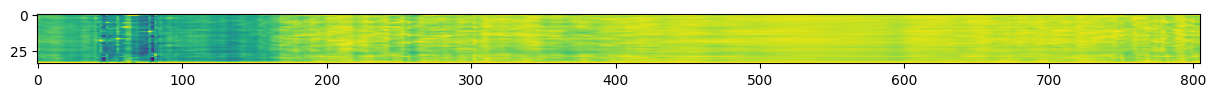

In [10]:
plt.figure(figsize=(15, 8))
plt.imshow(logprobs[0].T.cpu())
plt.show()

## Считаем WER

In [11]:
from src.metrics import WER

def calculate_greedy_wer(preds_list, encoded_len_list, targets_list):
    metric = WER()
    refs = []
    hyps = []
    for pred_batch, encoded_len_batch, targets_batch in tqdm(zip(preds_list, encoded_len_list, targets_list), total=len(preds_list)):
        for pred, pred_len, target in zip(pred_batch, encoded_len_batch, targets_batch):
            hyps.append(model.decoder.decode_hypothesis(pred[:pred_len], unique_consecutive=True))
            refs.append(model.decoder.decode_hypothesis(target, unique_consecutive=False))
    
    metric.update(refs, hyps)
    wer = metric.compute()
    return wer[0]

In [12]:
wer = calculate_greedy_wer(preds_list, encoded_len_list, targets_list)
print('WER: ', wer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.17it/s]

WER:  tensor(0.2719)


## Рескоринг

Будем использовать 3-Gram LM, полученную с помощью фрэймворка [KenLM](https://github.com/kpu/kenlm) и данных из датасетов [Golos](https://github.com/salute-developers/golos/blob/master/golos/README_ru.md) и [Common Crawl](https://commoncrawl.org/).
Скачать модель можно из репозитория датасета Golos, по этой [ссылке](https://n-ws-3jtx8.s3pd12.sbercloud.ru/b-ws-3jtx8-eir/golos/kenlms.tar)

In [13]:
import kenlm
from torchaudio.models.decoder import ctc_decoder
import editdistance

LM_PATH = '/home/malex26/repos/speech-tech-mipt/week07/asr/kenlms/lm_50x50.binary'
lm_model = kenlm.LanguageModel(LM_PATH)

/usr/local/lib/python3.10/dist-packages/torchaudio-2.1.0-py3.10-linux-x86_64.egg/torchaudio/models/decoder/_ctc_decoder.py:62: UserWarning: The built-in flashlight integration is deprecated, and will be removed in future release. Please install flashlight-text. https://pypi.org/project/flashlight-text/ For the detail of CTC decoder migration, please see https://github.com/pytorch/audio/issues/3088.
  warnings.warn(


In [14]:
def calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder):
    metric = WER()
    refs = []
    hyps = []
    best_hyps = []
    rescored_hyps = []
    n_bests = []
    # Итерация по нашему куску даталоадера
    for logprob_batch, encoded_len_batch, targets_batch in tqdm(zip(logprobs_list, encoded_len_list, targets_list), total=len(logprobs_list)):
        beamsearch_result = beam_search_decoder(logprob_batch.cpu(), encoded_len_batch.cpu())
        
        # Итерация по батчу
        for i in range(len(beamsearch_result)):
            ref = model.decoder.decode_hypothesis(targets_batch[i], unique_consecutive=False)
            refs.append(ref)
            
            # Итерация по n-best списку
            best_distance = 10000
            best_hyp = None
            best_rescored_hyp = None
            best_score = -100000
            n_bests.append([])
            for j in range(len(beamsearch_result[i])):
                curr_tokens = beamsearch_result[i][j].tokens
                curr_hyp = model.decoder.decode(curr_tokens.unsqueeze(0), [len(curr_tokens)])[0]
                n_bests[-1].append({'hyp': curr_hyp, 'score':beamsearch_result[i][j].score})
                if j == 0:
                    hyps.append(curr_hyp)
                
                distance = editdistance.eval(ref.split(), curr_hyp.split())
                if distance < best_distance:
                    best_hyp = curr_hyp
                    best_distance = distance
                score = lm_model.score(curr_hyp)
                if score > best_score:
                    best_score = score
                    best_rescored_hyp = curr_hyp
                    
            best_hyps.append(best_hyp)
            rescored_hyps.append(best_rescored_hyp)
    
    metric.update(refs, hyps)
    wer = metric.compute()
    
    metric.reset()
    metric.update(refs, best_hyps)
    oracle_wer = metric.compute()
    
    metric.reset()
    metric.update(refs, rescored_hyps)
    rescored_wer = metric.compute()
    output = {
        'wer': wer[0],
        'oracle_wer': oracle_wer[0],
        'rescored_wer': rescored_wer[0],
        'references': refs,
        'hypotheses': hyps,
        'oracle_hypotheses': best_hyps,
        'rescored_hypotheses': rescored_hyps,
        'n_bests': n_bests
    }
    return output

In [15]:
TOKENS = cfg.model.labels + ['-']

beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=TOKENS,
    nbest=5,
    beam_size=50,
    sil_token=' ',
    blank_token='-',
)
output = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder)
n_bests = output['n_bests']
refs = output['references']

print('WER: ', output['wer'])
print('Oracle WER: ', output['oracle_wer'])
print('Rescored WER: ', output['rescored_wer'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:28<00:00,  4.72s/it]

WER:  tensor(0.2719)
Oracle WER:  tensor(0.2081)
Rescored WER:  tensor(0.2350)


In [65]:
def print_nbest_with_scores(n_bests, ref):
    wers = [editdistance.eval(ref.split(), n_best['hyp'].split()) / len(ref.split()) for n_best in n_bests]
    scores = [lm_model.score(n_best['hyp']) for n_best in n_bests]
    print('REFERENCE:')
    print(f'{ref.strip()} | SCORE = {lm_model.score(ref)}')
    print('-'*50)
    print('N_BEST LIST:')
    oracle_index = np.argmin(wers)
    rescored_index = np.argmax(scores)
    for i in range(len(wers)):
        additional = '| **ORACLE HYP** ' if oracle_index == i else ''
        additional += '| **RESCORED HYP**' if rescored_index == i else ''
        hyp = n_bests[i]['hyp'].strip()
        am_score = n_bests[i]['score']
        print(f'{i}: {hyp}  {additional}\nWER = {wers[i]} | ACOUSTIC_SCORE: {am_score} | LM_SCORE = {scores[i]}')
        print()

In [66]:
index = np.random.randint(500)
print_nbest_with_scores(n_bests[index], refs[index])

REFERENCE:
случайная связь поищи | SCORE = -10.397027015686035
--------------------------------------------------
N_BEST LIST:
0: случайныя связь поищи  
WER = 0.3333333333333333 | ACOUSTIC_SCORE: -3.430824262987528 | LM_SCORE = -18.315706253051758

1: случайная связь поищи  | **ORACLE HYP** | **RESCORED HYP**
WER = 0.0 | ACOUSTIC_SCORE: -3.774919493090067 | LM_SCORE = -10.397027015686035

2: случайные связь поищи  
WER = 0.3333333333333333 | ACOUSTIC_SCORE: -4.808433962952051 | LM_SCORE = -13.643535614013672

3: случайнае связь поищи  
WER = 0.3333333333333333 | ACOUSTIC_SCORE: -5.1525291930545905 | LM_SCORE = -16.754453659057617

4: случайноя связь поищи  
WER = 0.3333333333333333 | ACOUSTIC_SCORE: -5.245886189829264 | LM_SCORE = -17.843372344970703



In [67]:
BEAM_SIZE = 20
N_BESTS = [2, 5, 10, 20, 50]
wer_results = []
oracle_wer_results = []
rescored_wer_results = []

for n_best in N_BESTS:
    beam_search_decoder = ctc_decoder(
        lexicon=None,
        tokens=TOKENS,
        nbest=n_best,
        beam_size=BEAM_SIZE,
        sil_token=' ',
        blank_token='-',
    )
    output = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder)
    wer_results.append(output['wer'])
    oracle_wer_results.append(output['oracle_wer'])
    rescored_wer_results.append(output['rescored_wer'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.90s/it]


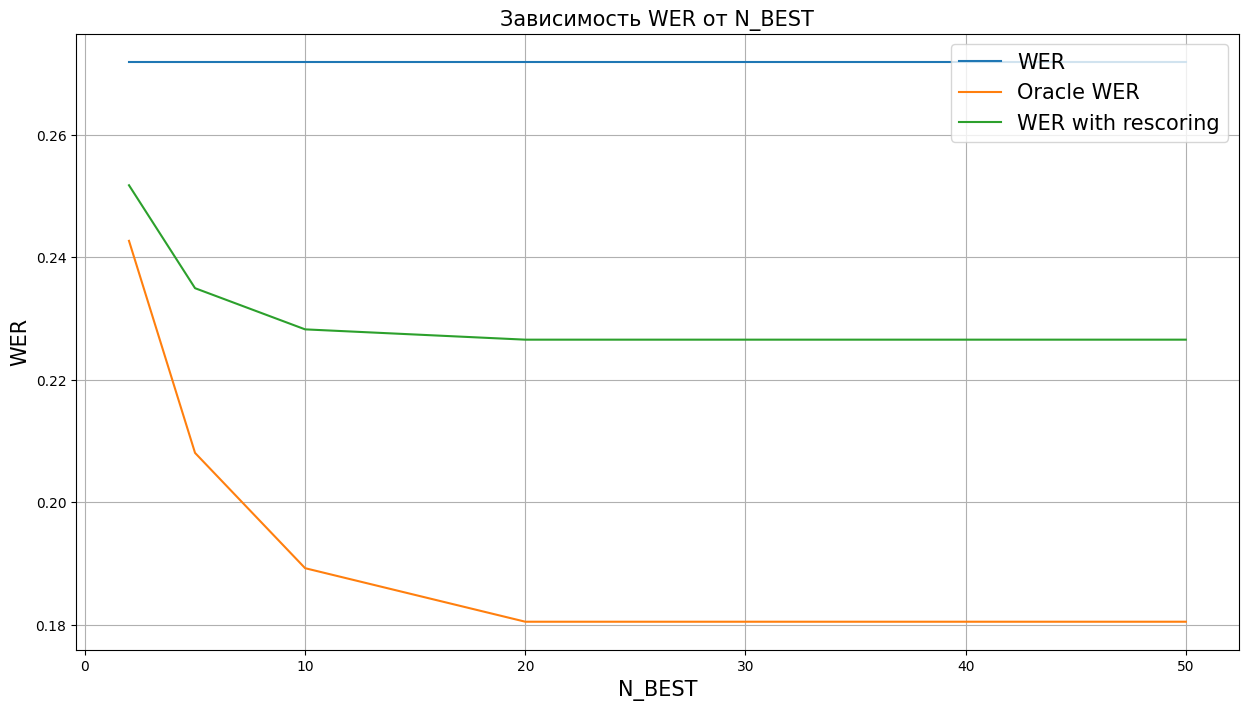

In [68]:
plt.figure(figsize=(15, 8))
plt.plot(N_BESTS, wer_results, label='WER')
plt.plot(N_BESTS, oracle_wer_results, label='Oracle WER')
plt.plot(N_BESTS, rescored_wer_results, label='WER with rescoring')
plt.ylabel('WER', fontsize=15)
plt.xlabel('N_BEST', fontsize=15)
plt.title('Зависимость WER от N_BEST', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

In [69]:
N_BEST = 10
BEAM_SIZES = [2, 5, 10, 20, 50]
wer_results = []
oracle_wer_results = []
rescored_wer_results = []

for beam_size in BEAM_SIZES:
    beam_search_decoder = ctc_decoder(
        lexicon=None,
        tokens=TOKENS,
        nbest=N_BEST,
        beam_size=beam_size,
        sil_token=' ',
        blank_token='-',
    )
    output = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder)
    wer_results.append(output['wer'])
    oracle_wer_results.append(output['oracle_wer'])
    rescored_wer_results.append(output['rescored_wer'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.22s/it]


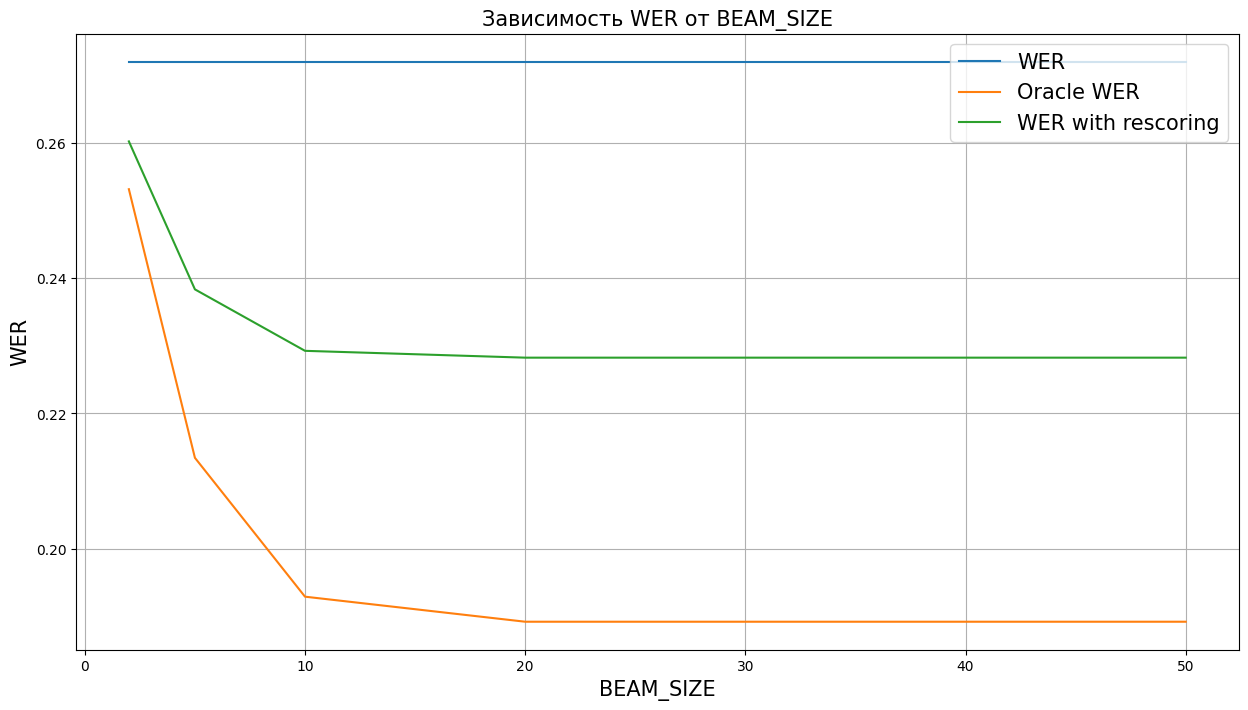

In [70]:
plt.figure(figsize=(15, 8))
plt.plot(BEAM_SIZES, wer_results, label='WER')
plt.plot(BEAM_SIZES, oracle_wer_results, label='Oracle WER')
plt.plot(BEAM_SIZES, rescored_wer_results, label='WER with rescoring')
plt.ylabel('WER', fontsize=15)
plt.xlabel('BEAM_SIZE', fontsize=15)
plt.title('Зависимость WER от BEAM_SIZE', fontsize=15)
plt.legend(fontsize=15)
plt.grid()